# Single queue simulation

This notebook provides a simple, single queue simulation. We generate jobs, run them through the system and compare the behavior to Little's Law for verification.

The goal is to develop intuitions about the underlying dynamics of the system, especially around inputs, outputs, and how queueing processes convert inputs into outputs. On the input side we want to understand how to reduce response times to queueing parameters. On the output side we want to understand the performance metrics available and how we can measure them.

**Reduction of response times to queueing parameters.** First we show how to reduce response times to the following queueing network parameters:

- mean arrival rate
- mean service rate

Eventually we will also incorporate

- job scheduling policy: policy around how we prioritize waiting jobs; and
- job assignment policy: policy around how we assign jobs to resources

though this notebook simply assumes First-Come-First-Served (FCFS) scheduling, and assumes a single resource (which makes assignment not applicable).

**Performance measurement.** We show how to measure the following performance metrics:

- response time
- number of jobs in the system
- wait time
- device utilization
- throughput

**Little's Law** for open systems is

$$ {\mathbb E}[N] = \lambda {\mathbb E}[T] $$

where

- $\lambda$ = mean job arrival rate
- $N$ = number of jobs in the system
- $T$ = response time (departure time minus arrival time)
- ${\mathbb E}$ is the expectation operator

## 0 Setup 

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
rng = np.random.default_rng(42)

## 1 Simulation 

In [3]:
def run_sim(num_events, mean_arrival_rate, mean_service_rate):
    params = _build_params(num_events, mean_arrival_rate, mean_service_rate)
    arrival_times = _generate_arrival_times(params)
    service_times = _generate_service_times(params)
    jobs_df = _build_jobs_df(params, arrival_times, service_times)
    display(jobs_df.head(10))
    intervals_df = _build_intervals_df(params, jobs_df["arrive_time"], jobs_df["depart_time"])
    display(intervals_df.head(10))
    _plot_jobs_over_time(intervals_df)
    _verify_littles_law(params, jobs_df, intervals_df)
    _estimate_throughput(intervals_df)
    _estimate_util(intervals_df)
    _estimate_wait_time(params, jobs_df)

def _build_params(num_events, mean_arrival_rate, mean_service_rate):
    return {
        "num_events": num_events,
        "mean_arrival_rate": mean_arrival_rate,
        "mean_service_rate": mean_service_rate,
        "mean_interarrival_time": 1.0 / mean_arrival_rate,
        "mean_service_time": 1.0 / mean_service_rate,
        "num_bins": int(num_events / mean_arrival_rate)
    }

def _generate_arrival_times(params):
    interarrival_times = rng.exponential(
        scale=params["mean_interarrival_time"],
        size=params["num_events"])
    _dump_interarrival_stats(params, interarrival_times)
    _plot_interarrival_times(params, interarrival_times)
    arrival_times = np.cumsum(interarrival_times)
    _plot_arrival_times(params, arrival_times)
    return arrival_times

def _dump_interarrival_stats(params, interarrival_times):
    print("interarrival_times:")
    print(f"    mean, actual   = {params['mean_interarrival_time']}")
    print(f"    mean, observed = {np.mean(interarrival_times)}")
    print(f"    data[0:15]     = {interarrival_times[0:15]}")
    
def _plot_interarrival_times(params, interarrival_times):
    plt.figure(figsize=(12, 4))
    plt.title("Histogram of interarrival times")
    plt.xlabel("Interarrival time")
    plt.ylabel("Count")
    plt.hist(interarrival_times, bins=params["num_bins"])
    plt.show()

def _plot_arrival_times(params, arrival_times):
    plt.figure(figsize=(12, 4))
    plt.title("Histogram of arrival times")
    plt.xlabel("Arrival time")
    plt.ylabel("Count")
    plt.hist(arrival_times, bins=params["num_bins"])
    plt.show()

def _generate_service_times(params):
    service_times = rng.exponential(scale=params["mean_service_time"], size=params["num_events"])
    _dump_service_stats(params, service_times)
    _plot_service_times(params, service_times)
    return service_times

def _dump_service_stats(params, service_times):
    print("service_times:")
    print(f"    mean, actual   = {params['mean_service_time']}")
    print(f"    mean, observed = {np.mean(service_times)}")
    print(f"    data[0:15]     = {service_times[0:15]}")

def _plot_service_times(params, service_times):
    plt.figure(figsize=(12, 4))
    plt.title("Histogram of service times")
    plt.xlabel("Service time")
    plt.ylabel("Count")
    plt.hist(service_times, bins=params["num_bins"])
    plt.show()

def _build_jobs_df(params, arrival_times, service_times):    
    num_events = params["num_events"]
    
    jobs_df = pd.DataFrame({
        "arrive_time": arrival_times,
        "service_time": service_times,
        "start_time": np.zeros(num_events),
        "depart_time": np.zeros(num_events)
    })
    
    jobs_df.loc[0, "start_time"] = jobs_df.loc[0, "arrive_time"]
    jobs_df.loc[0, "depart_time"] = jobs_df.loc[0, "start_time"] + jobs_df.loc[0, "service_time"]
    
    for i in range(1, num_events):
        jobs_df.loc[i, "start_time"] = max(jobs_df.loc[i, "arrive_time"], jobs_df.loc[i-1, "depart_time"])
        jobs_df.loc[i, "depart_time"] = jobs_df.loc[i, "start_time"] + jobs_df.loc[i, "service_time"]
    
    jobs_df["response_time"] = jobs_df["depart_time"] - jobs_df["arrive_time"]
    jobs_df["wait_time"] = jobs_df["start_time"] - jobs_df["arrive_time"]
        
    return jobs_df

# Build intervals and their corresponding job counts so we can calculate E[N].
# To do this, we will have two pointers: one for the arrival times and the other for the end (departure) times.
# At each iteration, the lower-valued pointer is the next interval's upper bound. We increment the job count
# whenever we choose the arrival time and we decrement the job count whenever we choose the end time.
def _build_intervals_df(params, arrivals, departures):
    intervals_df = pd.DataFrame(columns=["lo_bd", "up_bd", "width", "num_jobs"])

    lo_bd = 0.0
    arrival_idx = 0
    end_idx = 0
    num_jobs = 0
    num_events = params["num_events"]
    
    while arrival_idx < num_events and end_idx < num_events:
        num_jobs_orig = num_jobs
        curr_arrival = arrivals[arrival_idx]
        curr_end = departures[end_idx]
        if curr_arrival < curr_end:
            num_jobs = num_jobs + 1
            up_bd = curr_arrival
            arrival_idx = arrival_idx + 1
        else:
            num_jobs = num_jobs - 1
            up_bd = curr_end
            end_idx = end_idx + 1

        width = up_bd - lo_bd
        intervals_df = intervals_df.append({
            "lo_bd": lo_bd,
            "up_bd": up_bd,
            "width": width,
            "num_jobs": num_jobs,
            "num_jobs_change": num_jobs - num_jobs_orig,
            "weighted_num_jobs": width * num_jobs
        }, ignore_index=True)

        lo_bd = up_bd
    
    return intervals_df

def _plot_jobs_over_time(intervals_df):
    intervals_df.plot(
        x="lo_bd",
        y="num_jobs",
        title="Job count over time",
        xlabel="Time",
        ylabel="Job count",
        figsize=(14, 4))
    plt.show()

def _verify_littles_law(params, jobs_df, intervals_df):
    mean_arrival_rate = params["mean_arrival_rate"]
    
    # Estimate E[N]
    total_weighted_num_jobs = intervals_df["weighted_num_jobs"].sum()
    total_width = intervals_df.iloc[-1]["up_bd"]
    mean_num_jobs = total_weighted_num_jobs / total_width

    # Estimate E[T]
    mean_response_time = jobs_df["response_time"].mean()
    
    print("Little's Law:")
    print(f"    E[N]          = {mean_num_jobs}")
    print(f"    lambda * E[T] = {mean_arrival_rate * mean_response_time} (= {mean_arrival_rate} * {mean_response_time})")

def _estimate_throughput(intervals_df):
    total_width = intervals_df.iloc[-1]["up_bd"]
    completions = intervals_df.loc[intervals_df["num_jobs_change"] == -1.0, "up_bd"]
    completion_counts, _, _ = plt.hist(completions, bins=int(total_width))
    plt.show()
    
    # Jobs completed per bin
    mean_throughput = np.mean(completion_counts)
    print(f"\nmean_throughput = {mean_throughput}")
    mean_throughput

def _estimate_util(intervals_df):
    busy = intervals_df.loc[intervals_df["num_jobs"] > 0.0, "width"].sum()
    total_width = intervals_df.iloc[-1]["up_bd"]
    util = busy / total_width
    print(f"\nutilization = {util}")

def _estimate_wait_time(params, jobs_df):
    mean_wait_time = np.mean(jobs_df["wait_time"])
    mean_response_time = jobs_df["response_time"].mean()
    # Note: E[response_time] = E[wait_time] + E[service_time]
    print(f"\nmean_response_time                 = {mean_response_time}")
    print(f"mean_wait_time + mean_service_time = {mean_wait_time + params['mean_service_time']}")

## Simulation: n=4000, $\lambda$=16, $\mu$=64 

interarrival_times:
    mean, actual   = 0.0625
    mean, observed = 0.06250397901153028
    data[0:15]     = [0.15026304 0.14601185 0.14904756 0.01748714 0.00540234 0.09079128
 0.08812254 0.1952685  0.00495589 0.06541005 0.00440227 0.06806398
 0.10820796 0.02418093 0.0769741 ]


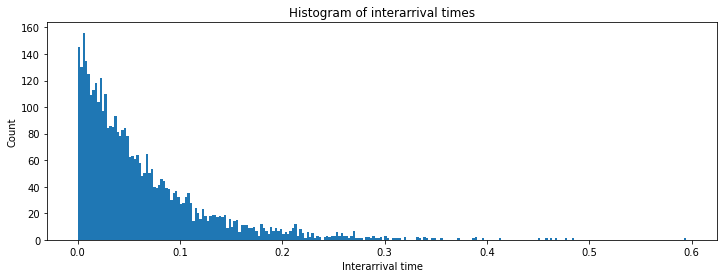

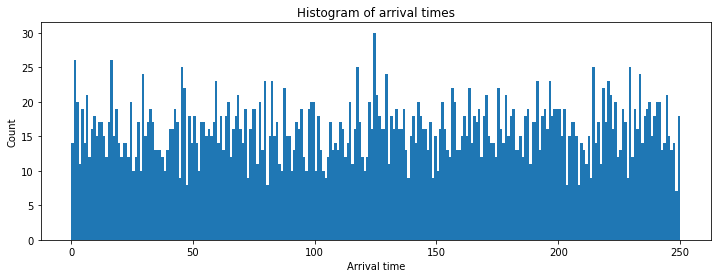

service_times:
    mean, actual   = 0.015625
    mean, observed = 0.015146643178894024
    data[0:15]     = [0.00188031 0.0035744  0.00092427 0.0239792  0.01968601 0.00679415
 0.01693052 0.03481058 0.00293987 0.00743064 0.00172409 0.00024575
 0.00269414 0.01566148 0.01239548]


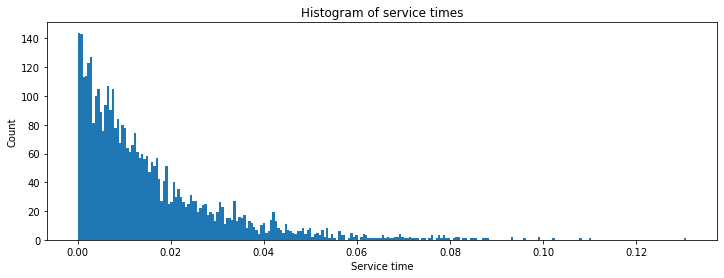

,arrive_time,service_time,start_time,depart_time,response_time,wait_time
0,0.150263,0.001880,0.150263,0.152143,0.001880,0.000000
1,0.296275,0.003574,0.296275,0.299849,0.003574,0.000000
2,0.445322,0.000924,0.445322,0.446247,0.000924,0.000000
3,0.462810,0.023979,0.462810,0.486789,0.023979,0.000000
4,0.468212,0.019686,0.486789,0.506475,0.038263,0.018577
5,0.559003,0.006794,0.559003,0.565797,0.006794,0.000000
6,0.647126,0.016931,0.647126,0.664056,0.016931,0.000000
7,0.842394,0.034811,0.842394,0.877205,0.034811,0.000000
8,0.847350,0.002940,0.877205,0.880145,0.032795,0.029855
9,0.912760,0.007431,0.912760,0.920191,0.007431,0.000000


,lo_bd,up_bd,width,num_jobs,num_jobs_change,weighted_num_jobs
0,0.000000,0.150263,0.150263,1.0,1.0,0.150263
1,0.150263,0.152143,0.001880,0.0,-1.0,0.000000
2,0.152143,0.296275,0.144132,1.0,1.0,0.144132
3,0.296275,0.299849,0.003574,0.0,-1.0,0.000000
4,0.299849,0.445322,0.145473,1.0,1.0,0.145473
5,0.445322,0.446247,0.000924,0.0,-1.0,0.000000
6,0.446247,0.462810,0.016563,1.0,1.0,0.016563
7,0.462810,0.468212,0.005402,2.0,1.0,0.010805
8,0.468212,0.486789,0.018577,1.0,-1.0,0.018577
9,0.486789,0.506475,0.019686,0.0,-1.0,0.000000


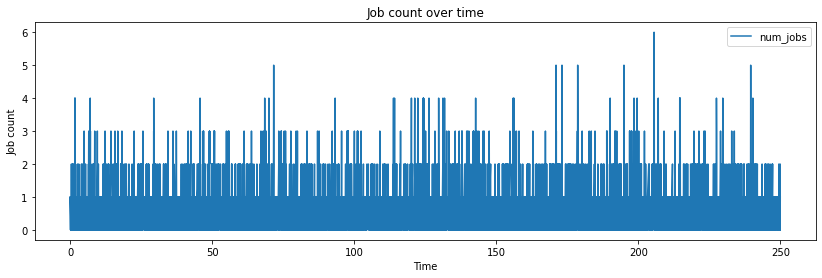

Little's Law:
    E[N]          = 0.9258647446096846
    lambda * E[T] = 0.32038776490279447 (= 16 * 0.020024235306424654)


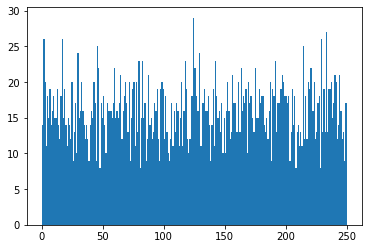


mean_throughput = 15.996

utilization = 0.8500375388791478

mean_response_time                 = 0.020024235306424654
mean_wait_time + mean_service_time = 0.020502592127530608


In [4]:
run_sim(4000, 16, 64)

## Simulation: n=4000, $\lambda$=16, $\mu$=32 

interarrival_times:
    mean, actual   = 0.0625
    mean, observed = 0.06363915819802572
    data[0:15]     = [0.03296994 0.13331424 0.10515361 0.08102744 0.00099626 0.07023736
 0.02213615 0.08956487 0.01574476 0.0002017  0.04384442 0.0212936
 0.05501775 0.02039632 0.09349969]


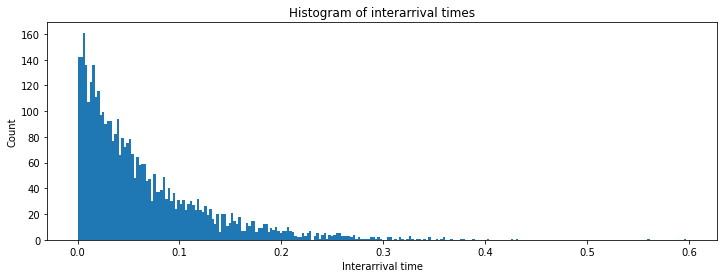

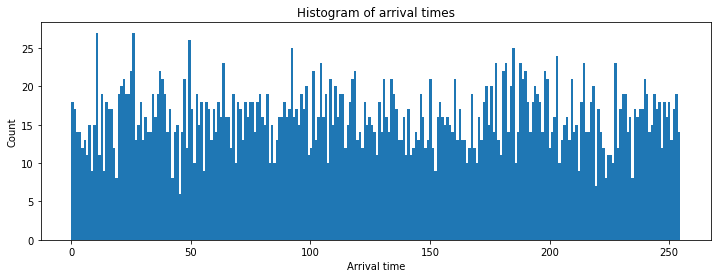

service_times:
    mean, actual   = 0.03125
    mean, observed = 0.03148194064452782
    data[0:15]     = [0.02735984 0.00016278 0.02020462 0.00728747 0.01288353 0.00893061
 0.05509483 0.00027133 0.02784808 0.00086445 0.07177116 0.13724978
 0.01516964 0.10738997 0.00058392]


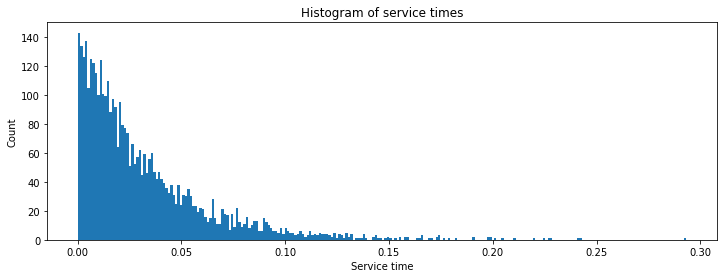

,arrive_time,service_time,start_time,depart_time,response_time,wait_time
0,0.032970,0.027360,0.032970,0.060330,0.027360,0.000000
1,0.166284,0.000163,0.166284,0.166447,0.000163,0.000000
2,0.271438,0.020205,0.271438,0.291642,0.020205,0.000000
3,0.352465,0.007287,0.352465,0.359753,0.007287,0.000000
4,0.353461,0.012884,0.359753,0.372636,0.019175,0.006291
5,0.423699,0.008931,0.423699,0.432629,0.008931,0.000000
6,0.445835,0.055095,0.445835,0.500930,0.055095,0.000000
7,0.535400,0.000271,0.535400,0.535671,0.000271,0.000000
8,0.551145,0.027848,0.551145,0.578993,0.027848,0.000000
9,0.551346,0.000864,0.578993,0.579857,0.028511,0.027646


,lo_bd,up_bd,width,num_jobs,num_jobs_change,weighted_num_jobs
0,0.000000,0.032970,0.032970,1.0,1.0,0.032970
1,0.032970,0.060330,0.027360,0.0,-1.0,0.000000
2,0.060330,0.166284,0.105954,1.0,1.0,0.105954
3,0.166284,0.166447,0.000163,0.0,-1.0,0.000000
4,0.166447,0.271438,0.104991,1.0,1.0,0.104991
5,0.271438,0.291642,0.020205,0.0,-1.0,0.000000
6,0.291642,0.352465,0.060823,1.0,1.0,0.060823
7,0.352465,0.353461,0.000996,2.0,1.0,0.001993
8,0.353461,0.359753,0.006291,1.0,-1.0,0.006291
9,0.359753,0.372636,0.012884,0.0,-1.0,0.000000


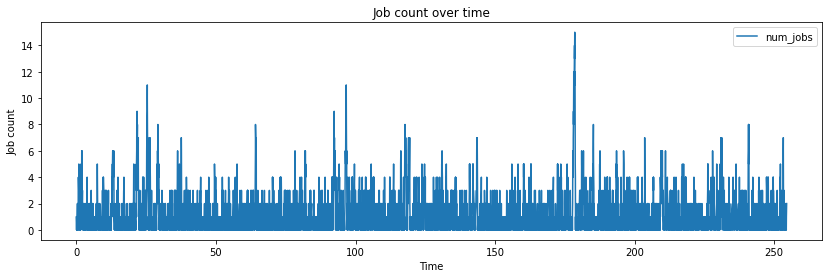

Little's Law:
    E[N]          = 1.3492646154832746
    lambda * E[T] = 1.0340351405525643 (= 16.0 * 0.06462719628453527)


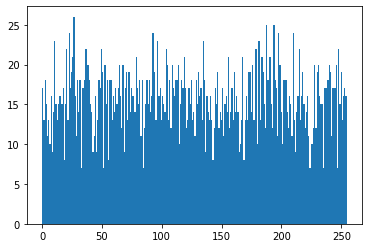


mean_throughput = 15.740157480314961

utilization = 0.8307565779417078

mean_response_time                 = 0.06462719628453527
mean_wait_time + mean_service_time = 0.06439525564000739


In [5]:
run_sim(4000, 16.0, 32.0)

## Simulation: n=4000, $\lambda$=16, $\mu$=18 

interarrival_times:
    mean, actual   = 0.0625
    mean, observed = 0.06192014918350118
    data[0:15]     = [0.00846334 0.00604013 0.10417634 0.02938973 0.00107451 0.06913997
 0.09262585 0.01166552 0.05193542 0.08880517 0.01376285 0.00771171
 0.0155382  0.07364033 0.00168287]


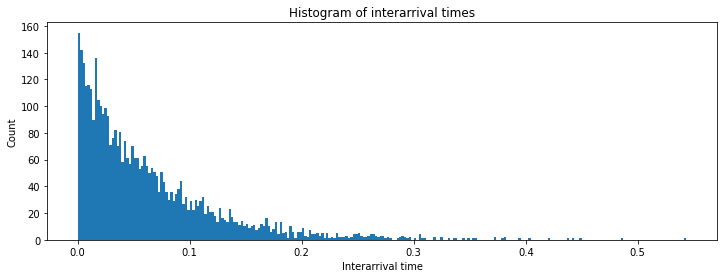

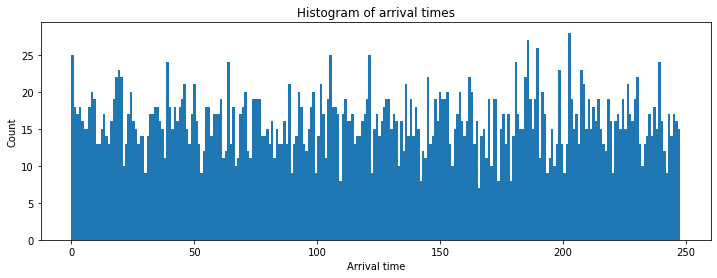

service_times:
    mean, actual   = 0.05555555555555555
    mean, observed = 0.05574601215132441
    data[0:15]     = [0.12708309 0.19253995 0.00568776 0.06675132 0.04858968 0.00501373
 0.06662884 0.04634116 0.0246739  0.08768664 0.15722482 0.11686947
 0.2297326  0.01566642 0.05771732]


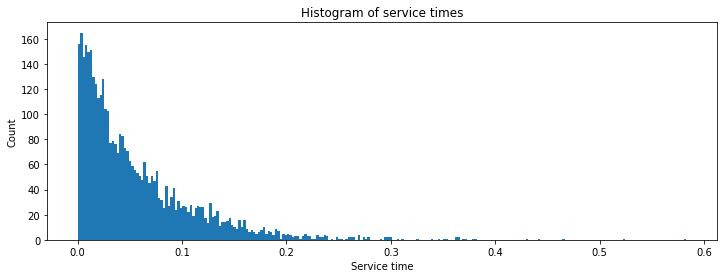

,arrive_time,service_time,start_time,depart_time,response_time,wait_time
0,0.008463,0.127083,0.008463,0.135546,0.127083,0.000000
1,0.014503,0.192540,0.135546,0.328086,0.313583,0.121043
2,0.118680,0.005688,0.328086,0.333774,0.215094,0.209407
3,0.148070,0.066751,0.333774,0.400525,0.252456,0.185705
4,0.149144,0.048590,0.400525,0.449115,0.299971,0.251381
5,0.218284,0.005014,0.449115,0.454129,0.235845,0.230831
6,0.310910,0.066629,0.454129,0.520758,0.209848,0.143219
7,0.322575,0.046341,0.520758,0.567099,0.244523,0.198182
8,0.374511,0.024674,0.567099,0.591773,0.217262,0.192588
9,0.463316,0.087687,0.591773,0.679459,0.216143,0.128457


,lo_bd,up_bd,width,num_jobs,num_jobs_change,weighted_num_jobs
0,0.000000,0.008463,0.008463,1.0,1.0,0.008463
1,0.008463,0.014503,0.006040,2.0,1.0,0.012080
2,0.014503,0.118680,0.104176,3.0,1.0,0.312529
3,0.118680,0.135546,0.016867,2.0,-1.0,0.033733
4,0.135546,0.148070,0.012523,3.0,1.0,0.037569
5,0.148070,0.149144,0.001075,4.0,1.0,0.004298
6,0.149144,0.218284,0.069140,5.0,1.0,0.345700
7,0.218284,0.310910,0.092626,6.0,1.0,0.555755
8,0.310910,0.322575,0.011666,7.0,1.0,0.081659
9,0.322575,0.328086,0.005511,6.0,-1.0,0.033066


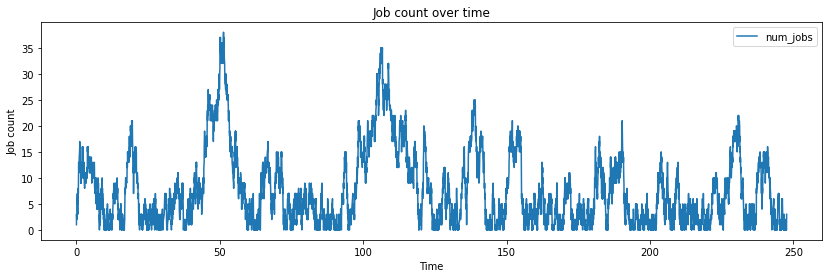

Little's Law:
    E[N]          = 7.713110137054575
    lambda * E[T] = 7.59102327451939 (= 16.0 * 0.4744389546574619)


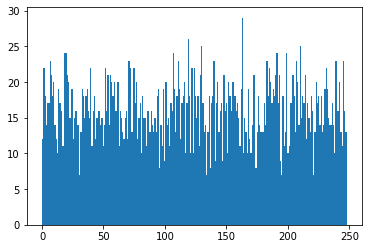


mean_throughput = 16.182186234817813

utilization = 0.9547929332151462

mean_response_time                 = 0.4744389546574619
mean_wait_time + mean_service_time = 0.4742484980616931


In [6]:
run_sim(4000, 16.0, 18.0)

## Simulation: n=4000, $\lambda$=16, $\mu$=16

interarrival_times:
    mean, actual   = 0.0625
    mean, observed = 0.06225971710143692
    data[0:15]     = [0.03698362 0.00926449 0.05974481 0.08181426 0.01392275 0.04075156
 0.07756318 0.02016971 0.05748885 0.04730043 0.11536395 0.05121649
 0.02113124 0.02131003 0.09598   ]


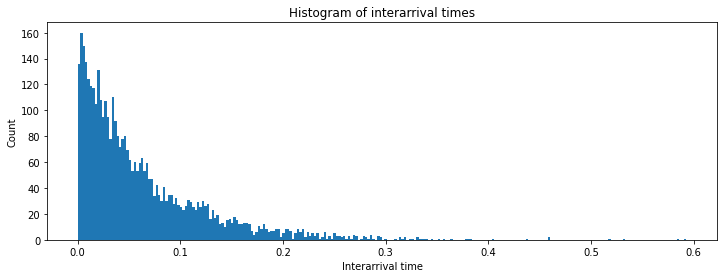

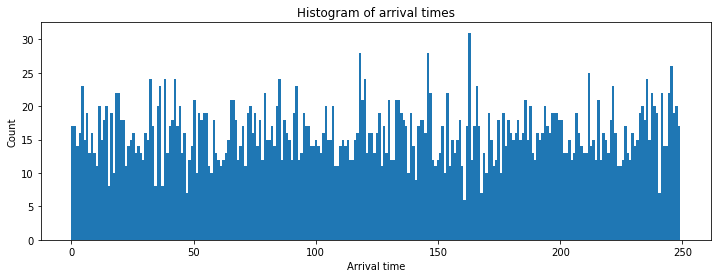

service_times:
    mean, actual   = 0.0625
    mean, observed = 0.06398319339398334
    data[0:15]     = [0.20789535 0.03107088 0.0028809  0.03959136 0.0618444  0.0047319
 0.00468865 0.1186631  0.0127054  0.03987868 0.00738604 0.04988311
 0.03188359 0.16988264 0.05393064]


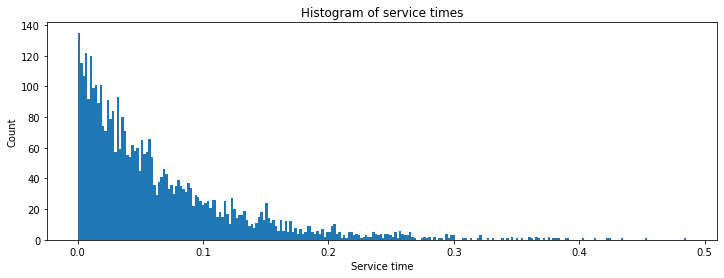

,arrive_time,service_time,start_time,depart_time,response_time,wait_time
0,0.036984,0.207895,0.036984,0.244879,0.207895,0.000000
1,0.046248,0.031071,0.244879,0.275950,0.229702,0.198631
2,0.105993,0.002881,0.275950,0.278831,0.172838,0.169957
3,0.187807,0.039591,0.278831,0.318422,0.130615,0.091024
4,0.201730,0.061844,0.318422,0.380267,0.178537,0.116692
5,0.242482,0.004732,0.380267,0.384998,0.142517,0.137785
6,0.320045,0.004689,0.384998,0.389687,0.069642,0.064954
7,0.340214,0.118663,0.389687,0.508350,0.168136,0.049473
8,0.397703,0.012705,0.508350,0.521056,0.123352,0.110647
9,0.445004,0.039879,0.521056,0.560934,0.115931,0.076052


,lo_bd,up_bd,width,num_jobs,num_jobs_change,weighted_num_jobs
0,0.000000,0.036984,0.036984,1.0,1.0,0.036984
1,0.036984,0.046248,0.009264,2.0,1.0,0.018529
2,0.046248,0.105993,0.059745,3.0,1.0,0.179234
3,0.105993,0.187807,0.081814,4.0,1.0,0.327257
4,0.187807,0.201730,0.013923,5.0,1.0,0.069614
5,0.201730,0.242482,0.040752,6.0,1.0,0.244509
6,0.242482,0.244879,0.002397,5.0,-1.0,0.011987
7,0.244879,0.275950,0.031071,4.0,-1.0,0.124284
8,0.275950,0.278831,0.002881,3.0,-1.0,0.008643
9,0.278831,0.318422,0.039591,2.0,-1.0,0.079183


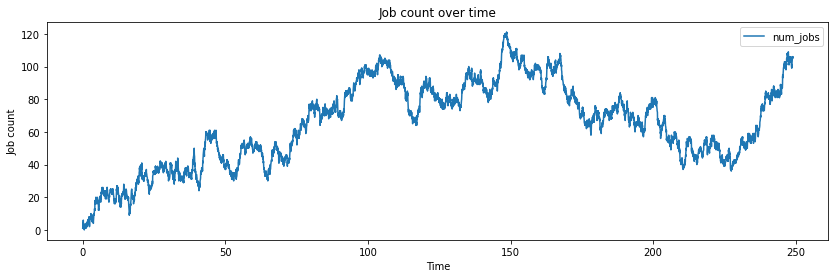

Little's Law:
    E[N]          = 64.70965818201519
    lambda * E[T] = 65.88687996590357 (= 16 * 4.117929997868973)


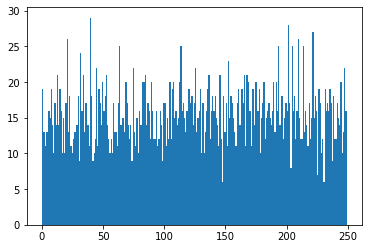


mean_throughput = 15.63855421686747

utilization = 0.9999703418147099

mean_response_time                 = 4.117929997868973
mean_wait_time + mean_service_time = 4.11644680447499


In [7]:
run_sim(4000, 16, 16)

## Simulation: n=4000, $\lambda$=16, $\mu$=15

interarrival_times:
    mean, actual   = 0.0625
    mean, observed = 0.06238316644460978
    data[0:15]     = [0.0604919  0.0233444  0.02855944 0.02818406 0.02943438 0.02066999
 0.01321542 0.09328998 0.02924635 0.17857528 0.03974501 0.28467325
 0.02518094 0.01933281 0.10202625]


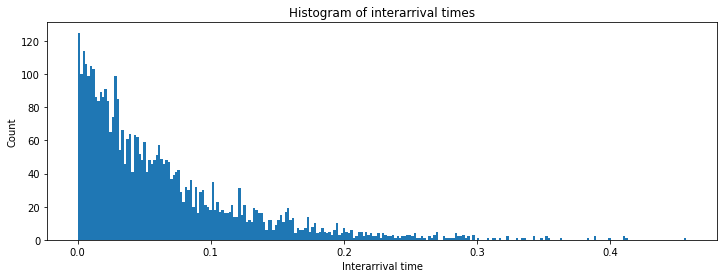

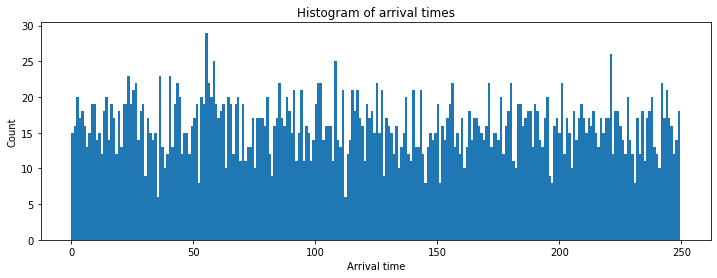

service_times:
    mean, actual   = 0.06666666666666667
    mean, observed = 0.06721896488332814
    data[0:15]     = [0.29214528 0.13412389 0.04522219 0.04067414 0.09787917 0.23225269
 0.01478165 0.04389584 0.00094494 0.05317469 0.02863603 0.01511405
 0.00533658 0.11683681 0.05114779]


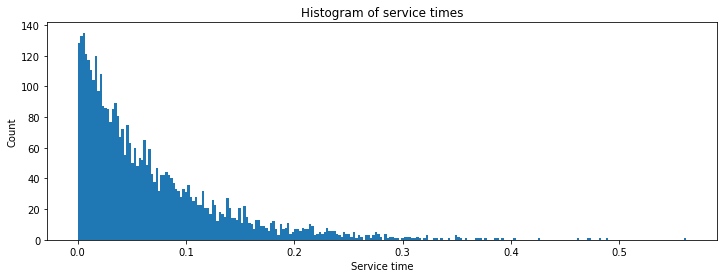

,arrive_time,service_time,start_time,depart_time,response_time,wait_time
0,0.060492,0.292145,0.060492,0.352637,0.292145,0.000000
1,0.083836,0.134124,0.352637,0.486761,0.402925,0.268801
2,0.112396,0.045222,0.486761,0.531983,0.419588,0.374365
3,0.140580,0.040674,0.531983,0.572657,0.432078,0.391403
4,0.170014,0.097879,0.572657,0.670537,0.500522,0.402643
5,0.190684,0.232253,0.670537,0.902789,0.712105,0.479852
6,0.203900,0.014782,0.902789,0.917571,0.713671,0.698890
7,0.297190,0.043896,0.917571,0.961467,0.664277,0.620381
8,0.326436,0.000945,0.961467,0.962412,0.635976,0.635031
9,0.505011,0.053175,0.962412,1.015586,0.510575,0.457400


,lo_bd,up_bd,width,num_jobs,num_jobs_change,weighted_num_jobs
0,0.000000,0.060492,0.060492,1.0,1.0,0.060492
1,0.060492,0.083836,0.023344,2.0,1.0,0.046689
2,0.083836,0.112396,0.028559,3.0,1.0,0.085678
3,0.112396,0.140580,0.028184,4.0,1.0,0.112736
4,0.140580,0.170014,0.029434,5.0,1.0,0.147172
5,0.170014,0.190684,0.020670,6.0,1.0,0.124020
6,0.190684,0.203900,0.013215,7.0,1.0,0.092508
7,0.203900,0.297190,0.093290,8.0,1.0,0.746320
8,0.297190,0.326436,0.029246,9.0,1.0,0.263217
9,0.326436,0.352637,0.026201,8.0,-1.0,0.209610


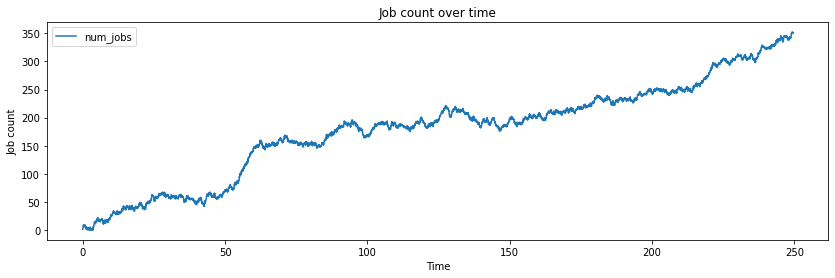

Little's Law:
    E[N]          = 178.58734113396505
    lambda * E[T] = 191.75970158746003 (= 16 * 11.984981349216252)


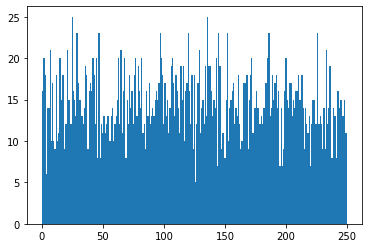


mean_throughput = 14.654618473895582

utilization = 0.9986241120656679

mean_response_time                 = 11.984981349216252
mean_wait_time + mean_service_time = 11.98442905099959


In [8]:
run_sim(4000, 16, 15)

## Simulation: n=4000, $\lambda$=16, $\mu$=12

interarrival_times:
    mean, actual   = 0.0625
    mean, observed = 0.06276076896820088
    data[0:15]     = [0.02247766 0.01862665 0.06946014 0.05074382 0.30926525 0.15440955
 0.05679451 0.09470801 0.03887595 0.21154633 0.0254983  0.1144167
 0.06613434 0.01343534 0.03840651]


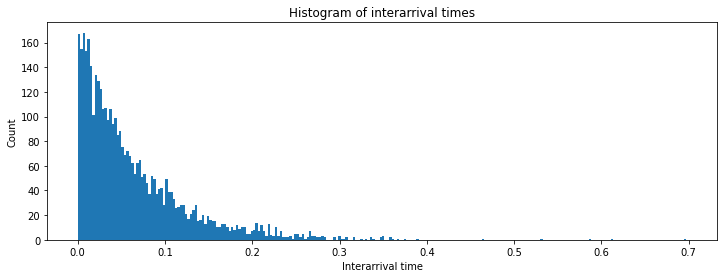

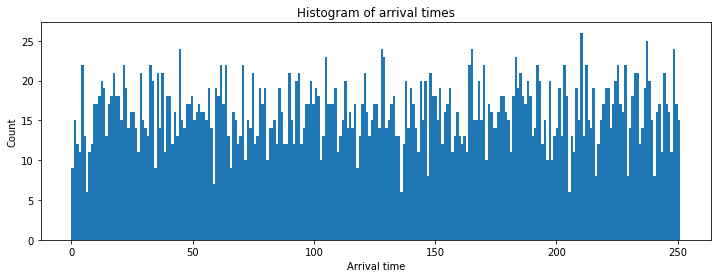

service_times:
    mean, actual   = 0.08333333333333333
    mean, observed = 0.08281662038274627
    data[0:15]     = [0.0287204  0.18944118 0.13159377 0.04882403 0.10540438 0.07468619
 0.23958574 0.13304867 0.02032145 0.03272129 0.00992795 0.02726936
 0.18615342 0.03557156 0.11845258]


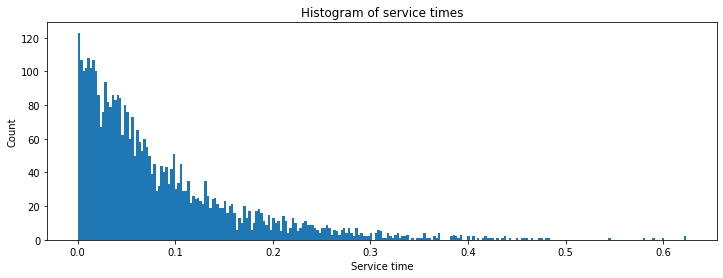

,arrive_time,service_time,start_time,depart_time,response_time,wait_time
0,0.022478,0.028720,0.022478,0.051198,0.028720,0.000000
1,0.041104,0.189441,0.051198,0.240639,0.199535,0.010094
2,0.110564,0.131594,0.240639,0.372233,0.261669,0.130075
3,0.161308,0.048824,0.372233,0.421057,0.259749,0.210925
4,0.470574,0.105404,0.470574,0.575978,0.105404,0.000000
5,0.624983,0.074686,0.624983,0.699669,0.074686,0.000000
6,0.681778,0.239586,0.699669,0.939255,0.257477,0.017892
7,0.776486,0.133049,0.939255,1.072304,0.295818,0.162769
8,0.815362,0.020321,1.072304,1.092625,0.277264,0.256942
9,1.026908,0.032721,1.092625,1.125346,0.098439,0.065717


,lo_bd,up_bd,width,num_jobs,num_jobs_change,weighted_num_jobs
0,0.000000,0.022478,0.022478,1.0,1.0,0.022478
1,0.022478,0.041104,0.018627,2.0,1.0,0.037253
2,0.041104,0.051198,0.010094,1.0,-1.0,0.010094
3,0.051198,0.110564,0.059366,2.0,1.0,0.118733
4,0.110564,0.161308,0.050744,3.0,1.0,0.152231
5,0.161308,0.240639,0.079331,2.0,-1.0,0.158662
6,0.240639,0.372233,0.131594,1.0,-1.0,0.131594
7,0.372233,0.421057,0.048824,0.0,-1.0,0.000000
8,0.421057,0.470574,0.049516,1.0,1.0,0.049516
9,0.470574,0.575978,0.105404,0.0,-1.0,0.000000


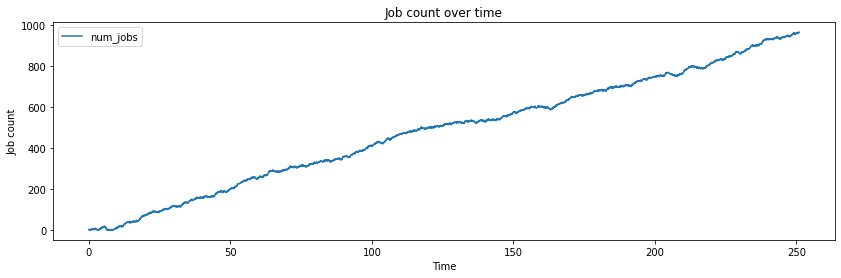

Little's Law:
    E[N]          = 483.5908793162312
    lambda * E[T] = 647.4074176871094 (= 16 * 40.46296360544434)


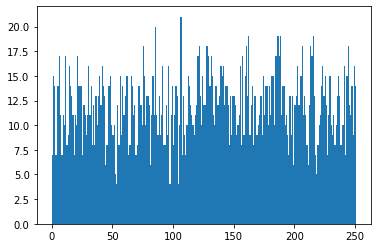


mean_throughput = 12.08366533864542

utilization = 0.9967227416331341

mean_response_time                 = 40.46296360544434
mean_wait_time + mean_service_time = 40.46348031839493


In [9]:
run_sim(4000, 16, 12)